In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, f1_score, auc


sns.set(style="whitegrid")
sns.set_color_codes("pastel")

In [2]:
full_train = pd.read_csv("datasets/train_clean.csv")

to_drop = ["Name", "Ticket", "Embarked", "PassengerId", *[c for c in full_train if "cabin" in c.lower()]]

full_train.drop(columns=to_drop, inplace=True)

target_col = "Survived"

X = full_train.drop(target_col, axis=1)
y = full_train[target_col]

X_train, y_train = X, y

model = ComplementNB()

param_grid = {
    "alpha": [0.1, 0.5, 1.0, 2.0, 5.0],
    "fit_prior": [True, False],
    "norm": [True, False]
}

grid_search = GridSearchCV(model, param_grid, n_jobs=1, cv=5, scoring='accuracy', verbose=4)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END alpha=0.1, fit_prior=True, norm=True;, score=0.747 total time=   0.0s
[CV 2/5] END alpha=0.1, fit_prior=True, norm=True;, score=0.803 total time=   0.0s
[CV 3/5] END alpha=0.1, fit_prior=True, norm=True;, score=0.787 total time=   0.0s
[CV 4/5] END alpha=0.1, fit_prior=True, norm=True;, score=0.753 total time=   0.0s
[CV 5/5] END alpha=0.1, fit_prior=True, norm=True;, score=0.791 total time=   0.0s
[CV 1/5] END alpha=0.1, fit_prior=True, norm=False;, score=0.764 total time=   0.0s
[CV 2/5] END alpha=0.1, fit_prior=True, norm=False;, score=0.798 total time=   0.0s
[CV 3/5] END alpha=0.1, fit_prior=True, norm=False;, score=0.775 total time=   0.0s
[CV 4/5] END alpha=0.1, fit_prior=True, norm=False;, score=0.753 total time=   0.0s
[CV 5/5] END alpha=0.1, fit_prior=True, norm=False;, score=0.774 total time=   0.0s
[CV 1/5] END alpha=0.1, fit_prior=False, norm=True;, score=0.747 total time=   0.0s
[CV 2/5] END alpha=

In [3]:
import joblib

joblib.dump(grid_search, f'../models/{grid_search.best_estimator_.__class__.__name__}_{grid_search.best_score_ * 100:.4f}.joblib')

['models/ComplementNB_78.1788.joblib']

In [4]:
model_name = grid_search.estimator.__class__.__name__

get_best = True  # get the best model or the latest model

# get files in models sorted by last modified
if get_best:
    import os
    import re
    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(files, key=lambda x: re.search(r"_(\d+\.\d+)\.joblib", x).group(1), reverse=True)
    file_name = files[0]
else:
    import os
    import re
    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(files, key=lambda x: os.path.getmtime(os.path.join("models", x)), reverse=True)
    file_name = files[0]
loaded_grid_search = joblib.load(f'../models/{file_name}')

In [5]:
for k, v in loaded_grid_search.cv_results_.items():
    print(k, v, sep="\t")

mean_fit_time	[0.0024869  0.00322828 0.002073   0.00205436 0.0015409  0.00155802
 0.00150614 0.00150261 0.00151954 0.0015388  0.00145917 0.00147896
 0.00177522 0.00151024 0.00147629 0.00153966 0.00152926 0.00145407
 0.00147586 0.00143657]
std_fit_time	[9.28237812e-04 2.14232058e-03 2.13127936e-04 4.10030096e-04
 6.98424022e-05 4.37138758e-05 1.93682778e-05 1.01971891e-04
 6.49610086e-05 7.80476829e-05 1.64106818e-05 5.30009167e-05
 3.04558338e-04 9.31299226e-05 1.00511233e-04 6.37385930e-05
 1.23687772e-04 1.40115497e-05 5.97936304e-05 2.66199869e-05]
mean_score_time	[0.00133429 0.00138712 0.00149503 0.00156426 0.00098767 0.00100617
 0.00096421 0.00099163 0.00098557 0.00102482 0.00096459 0.00096378
 0.00104132 0.0009737  0.00094781 0.00099316 0.00096335 0.00094762
 0.00096698 0.0009367 ]
std_score_time	[2.06835536e-04 2.97874185e-04 1.59691518e-04 7.84788541e-04
 1.51004624e-05 3.94371717e-05 8.92768549e-06 7.54033802e-05
 3.21642127e-05 1.05053687e-04 1.31588050e-05 4.72808990e-05
 7.

In [6]:
real_test = pd.read_csv("datasets/test_clean.csv")

In [7]:
real_test.drop(columns=list(set(to_drop)-{"PassengerId"}), inplace=True)

In [8]:
pred = pd.DataFrame(best_model.predict(real_test.drop(columns=["PassengerId"]))).rename(columns={0: "Survived"})

In [9]:
# get probabilities
probs = best_model.predict_proba(X_train)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# predict class values
yhat = best_model.predict(X_train)

# calculate roc-auc score
lr_auc = roc_auc_score(y_train, probs)

# calculate roc curve
ns_fpr, ns_tpr, _ = roc_curve(y_train, probs)

# get f1 score
lr_f1 = f1_score(y_train, best_model.predict(X_train))

# get auc score
lr_auc = auc(ns_fpr, ns_tpr)

# get precision & recall
lr_precision, lr_recall, _ = precision_recall_curve(y_train, probs)

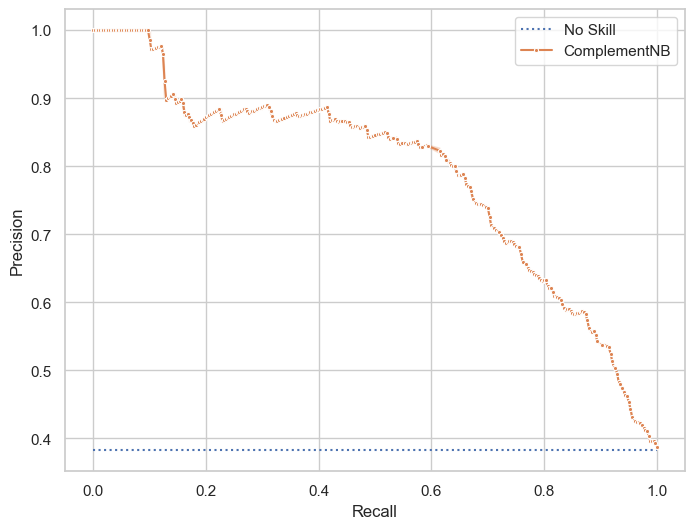

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get no-skill line
no_skill = len(y_train[y_train == 1]) / len(y_train)

# Set the style
sns.set(style="whitegrid")

# Plot the precision-recall curves
plt.figure(figsize=(8, 6))
sns.lineplot(
    x=[0, 1],
    y=[no_skill, no_skill],
    linestyle='dotted',
    label='No Skill'
)
sns.lineplot(
    x=lr_recall,
    y=lr_precision,
    marker='.',
    label=model_name
)

# Set axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# Show the legend
plt.legend()

# Show the plot
plt.show()

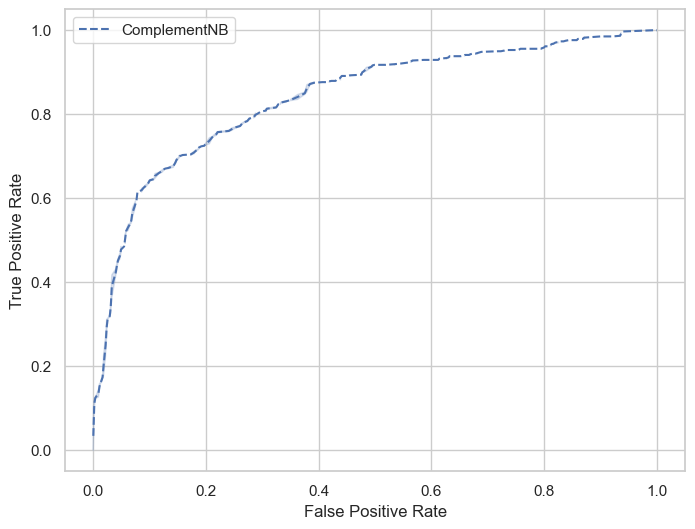

In [11]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(
    x=ns_fpr,
    y=ns_tpr,
    linestyle='--',
    label=model_name
)

# Set axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [12]:
pd.concat([real_test[["PassengerId"]], pred], axis=1).to_csv(f"../outs/{best_model.__class__.__name__}_{grid_search.best_score_ * 100:.4f}.csv", index=False)